# MD-GAN demo


Importing the python packages

In [1]:
from utils import simplex_params, get_noise
from architectures import build_discriminator, build_generator, build_lambda_network
from data import load_db
from iterators import iterator
from losses import get_gaussian_likelihood
import numpy as np
import theano
import theano.tensor as T
import lasagne
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 2)

/home/user/anaconda3/envs/env/lib/python3.6/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7402 on context None
Mapped name None to device cuda0: GeForce RTX 2080 Ti (0000:01:00.0)


Defining the variables

In [2]:
params = {
    'batch_size': 500,
    'zdim': 2, 
    'bot_dim': 9,
    'lr_d': 1e-3,
    'lr_g': 1e-3,
    'reg': 1e-8, # for avoiding numerical instabilities
    'samp_num_gen':2500
}

ngmm = params['bot_dim'] + 1

# Input variables
noise_t = T.matrix('noise')
input_t = T.matrix('inputs')

# Shared variables for the SGMM
mu_shared = theano.shared(lasagne.utils.floatX(np.zeros((ngmm, params['bot_dim']))))
sigma_shared = theano.shared(lasagne.utils.floatX(np.zeros((ngmm, params['bot_dim'], params['bot_dim']))))
w_shared = theano.shared(lasagne.utils.floatX(np.ones((ngmm,))))
lambda_shared = theano.shared(lasagne.utils.floatX(0))

ngmm_t = T.scalar('ngmm')
ngmm_t = T.cast(ngmm_t, 'float32')
comps_t = T.arange(0, ngmm_t)
feat_dim_t = T.scalar('feat_dim')
feat_dim_t = T.cast(feat_dim_t, 'int32')
lambda_t = T.scalar('lambda')

# Setting the learning rates
eta_d_shared = theano.shared(lasagne.utils.floatX(params['lr_d']))
eta_g_shared = theano.shared(lasagne.utils.floatX(params['lr_g']))

Setting the simplex parameters

In [3]:
mu_sgmm, sigma_sgmm, w_sgmm = simplex_params(params['bot_dim'])
mu_shared.set_value(mu_sgmm)
sigma_shared.set_value(sigma_sgmm)
w_shared.set_value(w_sgmm)

Defining the lambda network for computing lambda numerically

In [4]:
# Defining variables for the lambda network
lambda_input_var = T.fvector('lambda_inputs')
eta_lambda = theano.shared(lasagne.utils.floatX(0.01))

# Building the lambda network architecture
lambda_net = build_lambda_network(lambda_input_var, params['bot_dim'])

lambda_out = lasagne.layers.get_output(lambda_net)
lambda_out_det = lasagne.layers.get_output(lambda_net, deterministic=True)

# getting the likelihood for lambda network
lambda_lk_t, _ = theano.scan(fn=get_gaussian_likelihood, sequences=[comps_t],
                                          non_sequences=[lambda_out, mu_shared, sigma_shared,
                                                         w_shared,
                                                         feat_dim_t])
lambda_lk_det_t, _ = theano.scan(fn=get_gaussian_likelihood, sequences=[comps_t],
                                              non_sequences=[lambda_out_det, mu_shared, sigma_shared,
                                                             w_shared,
                                                             feat_dim_t])
lambda_loss = -T.log(params['reg'] + lambda_lk_t.sum(0))

# sum or average over batch samples
lambda_loss = lambda_loss.mean()
lambda_value = lambda_lk_det_t.sum(0)

# Preparing the parameters for lambda network
lambda_params = lasagne.layers.get_all_params(lambda_net, trainable=True)

# Defining the updates for lambda optimization
lambda_updates =  lasagne.updates.adam(lambda_loss, lambda_params, learning_rate=eta_lambda, beta1=0.9)

# Compiling the lambda functions
lambda_train_fn = theano.function([lambda_input_var, ngmm_t, feat_dim_t], updates=lambda_updates)
lambda_compute_fn = theano.function([lambda_input_var, ngmm_t, feat_dim_t], lambda_value)

/home/user/anaconda3/envs/env/lib/python3.6/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
/home/user/anaconda3/envs/env/lib/python3.6/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
/home/user/anaconda3/envs/env/lib/python3.6/site-packages/theano/scan_module/scan_perform_ext.py:76: Use

Training the lambda network on a fixed point

In [5]:
lambda_training_data = np.ones((1, ),dtype=np.float32)
for i in range(10001):
    if i % 1000 == 0 and i > 999:
        eta_old = eta_lambda.get_value()
        eta_new = eta_old * np.float32(0.5)
        eta_lambda.set_value(eta_new)
    lambda_train_fn(lambda_training_data, ngmm, params['bot_dim'])

Setting the computed lambda

In [6]:
# Finding the numerical lambda
lambdas_numeric = lambda_compute_fn(lambda_training_data, ngmm, params['bot_dim'])
lambda_numeric = lambdas_numeric.sum()

# Setting the numerical lambda
lambda_shared.set_value(lambda_numeric)

Building the MD-GAN architectures

In [7]:
# Discriminator
discriminator = build_discriminator(input_t, params['bot_dim'])

# Generator
generator = build_generator(noise_t, params['zdim'])

Defining the MD-GAN losses and updates

In [8]:
# Defining the outputs of the GAN networks
real_out_t = lasagne.layers.get_output(discriminator)
real_out_t = T.cast(real_out_t, 'float32')
fake_out_t = lasagne.layers.get_output(discriminator, lasagne.layers.get_output(generator))
fake_out_t = T.cast(fake_out_t, 'float32')

# returns lk for all clusters (real)
real_lk_t, _ = theano.scan(fn=get_gaussian_likelihood, sequences=[comps_t],
                                    non_sequences=[real_out_t, mu_shared, sigma_shared, w_shared,
                                                   feat_dim_t])

# returns lk for all clusters (fake)
fake_lk_t, _ = theano.scan(fn=get_gaussian_likelihood, sequences=[comps_t],
                                    non_sequences=[fake_out_t, mu_shared, sigma_shared, w_shared,
                                                   feat_dim_t])
  
# Computing the GAN losses
generator_loss = T.log(
    params['reg'] + lambda_shared - (fake_lk_t.sum(0) )
).mean()

discriminator_loss = -(
        T.log(
            params['reg'] +
            (real_lk_t.sum(0) )) +
        T.log(
            params['reg'] +
            lambda_shared - (fake_lk_t.sum(0) ))
).mean()

# Preparing the parameters of thenetworks
generator_params = lasagne.layers.get_all_params(generator, trainable=True)
discriminator_params = lasagne.layers.get_all_params(discriminator, trainable=True)

# Defining the updates
generator_updates = lasagne.updates.adam(
    generator_loss, generator_params, learning_rate=eta_g_shared, beta1=0.5)

discriminator_updates = lasagne.updates.adam(
    discriminator_loss, discriminator_params, learning_rate=eta_d_shared, beta1=0.5)


# Compiling the MD-GAN functions

# Training function for the discriminator
discriminator_train_fn = theano.function([input_t, noise_t, feat_dim_t, ngmm_t],
                                          updates=discriminator_updates)

# Training function for the generator
generator_train_fn = theano.function(
            [noise_t, feat_dim_t, ngmm_t], updates=generator_updates)

# Sampling function for the generator
gen_fn = theano.function([noise_t],
                             lasagne.layers.get_output(generator,
                                                       deterministic=True))

/home/user/anaconda3/envs/env/lib/python3.6/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
/home/user/anaconda3/envs/env/lib/python3.6/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
/home/user/anaconda3/envs/env/lib/python3.6/site-packages/theano/scan_module/scan_perform_ext.py:76: Use

Loading the training data

In [9]:
trainx = load_db()

Training the MD-GAN

In [10]:
# The training loop
for epoch in range(2000):
    for inputs in iterator(trainx, params['batch_size'],eta_d_shared, eta_g_shared, epoch):
        noise_z = get_noise(batchsize=params['batch_size'], zdim=params['zdim'])
        discriminator_train_fn(inputs, noise_z, params['bot_dim'], ngmm)
        noise_z = get_noise(batchsize=params['batch_size'], zdim=params['zdim'])
        generator_train_fn(noise_z, params['bot_dim'], ngmm)

Visualising the results

<IPython.core.display.Javascript object>


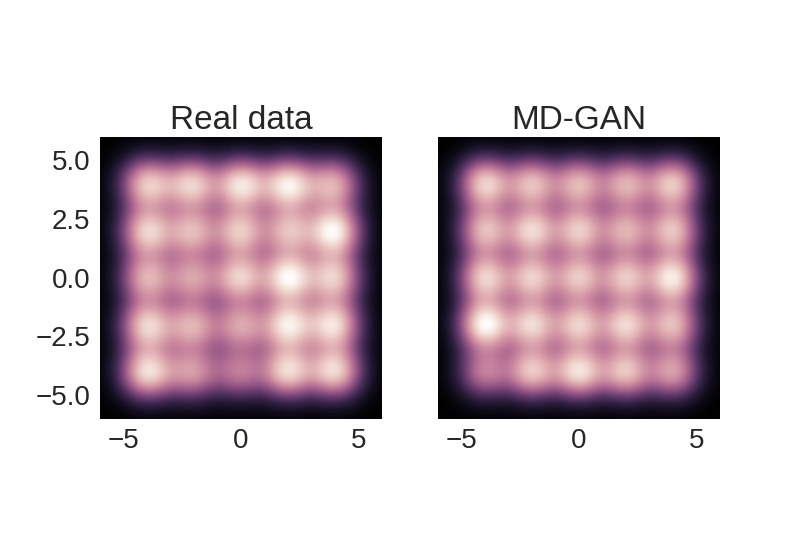

/home/user/anaconda3/envs/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


[None, None]

In [11]:
# Generating some samples
generated_examples = np.vstack([gen_fn(get_noise(batchsize=params['batch_size'], zdim=params['zdim'])) for _ in range(params['samp_num_gen']//params['batch_size'])])
real_examples = trainx[np.random.randint(0, trainx.shape[0], params['samp_num_gen'])]

# And plot them, along with the real data
%matplotlib notebook
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)

sns.kdeplot(real_examples[:, 0], real_examples[:,1], cmap=cmap, ax=ax2, n_levels=100, shade=True, clip=[[-6, 6]] * 2)
sns.kdeplot(generated_examples[:, 0], generated_examples[:,1], cmap=cmap, ax=ax1, n_levels=100, shade=True, clip=[[-6, 6]] * 2)

ax1.set_title('Real data')
ax1.set(adjustable='box-forced', aspect='equal')
ax2.set_title('MD-GAN')
ax2.set(adjustable='box-forced', aspect='equal')